In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas
import numpy as np

In [5]:
def plotScript(resultDir, script):
    quadratic = pandas.read_csv(f'results/{resultDir}/{script}/quadratic.tsv', sep='\t')
    bRTreePoint = pandas.read_csv(f'results/{resultDir}/{script}/bRTreePoint.tsv', sep='\t')
    bRTreeRule = pandas.read_csv(f'results/{resultDir}/{script}/bRTreeRule.tsv', sep='\t')
    xTreePoint = pandas.read_csv(f'results/{resultDir}/{script}/xTreePoint.tsv', sep='\t')
    xTreeRule = pandas.read_csv(f'results/{resultDir}/{script}/xTreeRule.tsv', sep='\t')

    groupedQuadratic = quadratic.groupby('dimensions')
    groupedBRTreePoint = bRTreePoint.groupby('dimensions')
    groupedBRTreeRule = bRTreeRule.groupby('dimensions')
    groupedXTreePoint = xTreePoint.groupby('dimensions')
    groupedXTreeRule = xTreeRule.groupby('dimensions')

    j = 1
    f = plt.figure(figsize=(14,8))
    for (i, group) in groupedQuadratic:
        ax = f.add_subplot(2, 3, j)
        ax.grid(True)
        ax.plot(groupedQuadratic.get_group(i)['rules'], groupedQuadratic.get_group(i)['timeNormUs'] / 1000, label="quadratic")
        ax.plot(groupedBRTreePoint.get_group(i)['rules'], groupedBRTreePoint.get_group(i)['timeNormUs'] / 1000, label="bulk r-tree (points)")
        ax.plot(groupedBRTreeRule.get_group(i)['rules'], groupedBRTreeRule.get_group(i)['timeNormUs'] / 1000, label="bulk r-tree (rules)")
        ax.plot(groupedXTreePoint.get_group(i)['rules'], groupedXTreePoint.get_group(i)['timeNormUs'] / 1000, label="x-tree (points)")
        ax.plot(groupedXTreeRule.get_group(i)['rules'], groupedXTreeRule.get_group(i)['timeNormUs'] / 1000, label="x-tree (rules)")
        ax.margins(0)
        plt.title(f'{i} dimensions')
        plt.xlabel('rules number')
        plt.ylabel('time per 1 point, ms')
        plt.legend(loc='upper left')
        j += 1


    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.5)
    plt.show()

In [6]:
def plotSpeedUp(resultDir, script):
    quadratic = pandas.read_csv(f'results/{resultDir}/{script}/quadratic.tsv', sep='\t')
    bRTreePoint = pandas.read_csv(f'results/{resultDir}/{script}/bRTreePoint.tsv', sep='\t')
    bRTreeRule = pandas.read_csv(f'results/{resultDir}/{script}/bRTreeRule.tsv', sep='\t')
    xTreePoint = pandas.read_csv(f'results/{resultDir}/{script}/xTreePoint.tsv', sep='\t')
    xTreeRule = pandas.read_csv(f'results/{resultDir}/{script}/xTreeRule.tsv', sep='\t')

    groupedQuadratic = quadratic.groupby('dimensions')
    groupedBRTreePoint = bRTreePoint.groupby('dimensions')
    groupedBRTreeRule = bRTreeRule.groupby('dimensions')
    groupedXTreePoint = xTreePoint.groupby('dimensions')
    groupedXTreeRule = xTreeRule.groupby('dimensions')

    j = 1
    f = plt.figure(figsize=(14,8))
    for (i, group) in groupedQuadratic:
        ax = f.add_subplot(2, 3, j)
        ax.grid(True)
        ax.plot(groupedBRTreePoint.get_group(i)['rules'], groupedQuadratic.get_group(i)['timeNormUs'] / groupedBRTreePoint.get_group(i)['timeNormUs'], label="bulk r-tree (points)")
        ax.plot(groupedBRTreeRule.get_group(i)['rules'], groupedQuadratic.get_group(i)['timeNormUs'] / groupedBRTreeRule.get_group(i)['timeNormUs'], label="bulk r-tree (rules)")
        ax.plot(groupedXTreePoint.get_group(i)['rules'], groupedQuadratic.get_group(i)['timeNormUs'] / groupedXTreePoint.get_group(i)['timeNormUs'], label="x-tree (points)")
        ax.plot(groupedXTreeRule.get_group(i)['rules'], groupedQuadratic.get_group(i)['timeNormUs'] / groupedXTreeRule.get_group(i)['timeNormUs'], label="x-tree (rules)")
        ax.margins(0)
        plt.title(f'{i} dimensions')
        plt.xlabel('rules number')
        plt.ylabel('time per 1 point, ms')
        plt.legend(loc='upper left')
        j += 1


    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.5)
    plt.show()

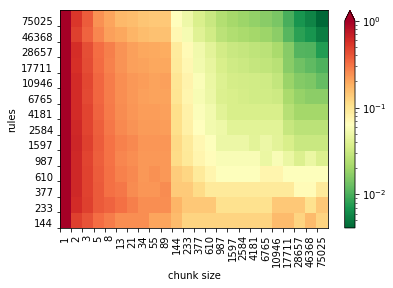

In [15]:
def plotPoint(resultDir):
    pointScript = pandas.read_csv(f'results/{resultDir}/pointScript/pointScript.tsv', sep='\t')  
    groupped = pointScript.groupby('rules')
    chunkSizes = [group for (i, group) in groupped['chunkSize']][0].to_numpy()
    ruleSizes = [i for (i, group) in groupped]
    array = np.array([group.to_numpy() / group.max() for (i, group) in groupped['timeNormUs']]) 
    
    ax = plt.gca()
    fig = plt.gcf()

    pcm = ax.pcolor(array, 
                    norm=colors.LogNorm(vmin=array.min(), vmax=array.max()), 
                    cmap='RdYlGn_r'
                   )
    fig.colorbar(pcm, ax=ax, extend='max')
    
    ax.set_yticks(np.arange(len(ruleSizes)))
    ax.set_xticks(np.arange(len(chunkSizes)))
    ax.set_yticklabels(ruleSizes, ha='right', rotation_mode='anchor')
    ax.set_xticklabels(chunkSizes, rotation='vertical', ha='right', rotation_mode='anchor')
    plt.xlabel('chunk size')
    plt.ylabel('rules')
        
    plt.show()
    
    
plotPoint(resultDir)

In [8]:
def plotIndex(resultDir, script):
    indices = ['quadratic', 'bRTreePoint', 'bRTreeRule', 'xTreePoint', 'xTreeRule']
    
    j = 1
    f = plt.figure(figsize=(14,8))
    for index in indices:
        df = pandas.read_csv(f'results/{resultDir}/{script}/{index}.tsv', sep="\t")
        ax = f.add_subplot(2, 3, j)
        ax.grid(True)
        grouped = df.groupby('dimensions')
        for (i, group) in grouped:
            ax.plot(group['rules'], group['timeNormUs'], label=f"{i} dimensions")
        plt.margins(0)
        plt.title(index)
        plt.legend(loc='upper left')
        j += 1

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.5)
    plt.show()

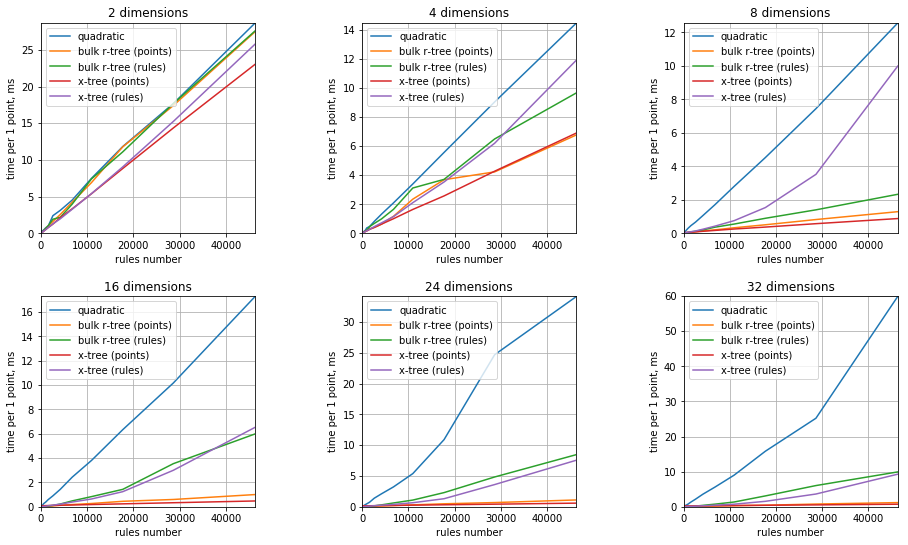

In [9]:
resultDir = 'reference'
plotScript(resultDir, 'uniform')

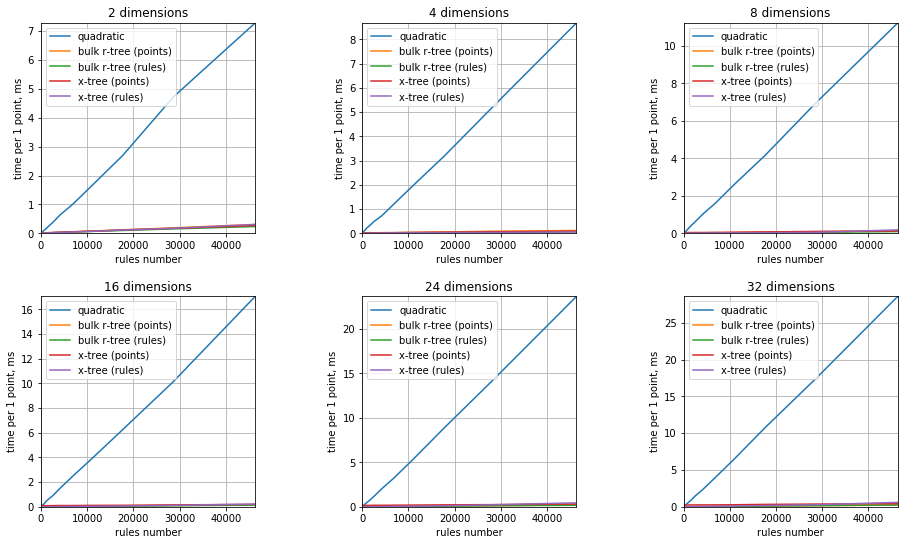

In [23]:
plotScript(resultDir, 'uniformLimited')

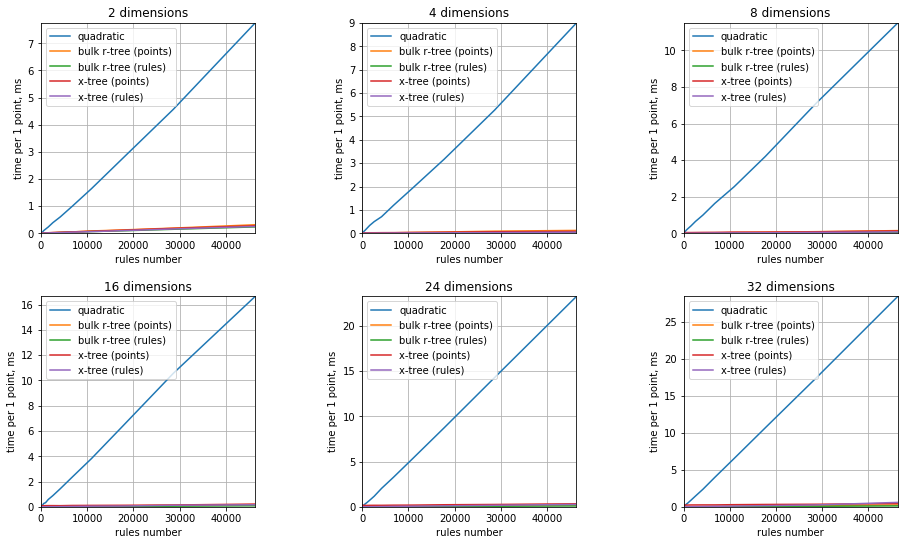

In [24]:
plotScript(resultDir, 'uniformDiscrete')

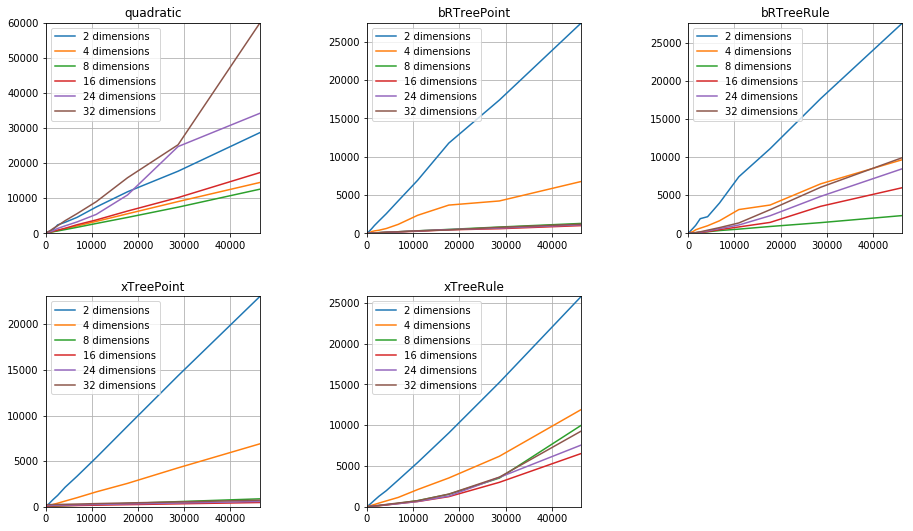

In [25]:
plotIndex(resultDir, 'uniform')

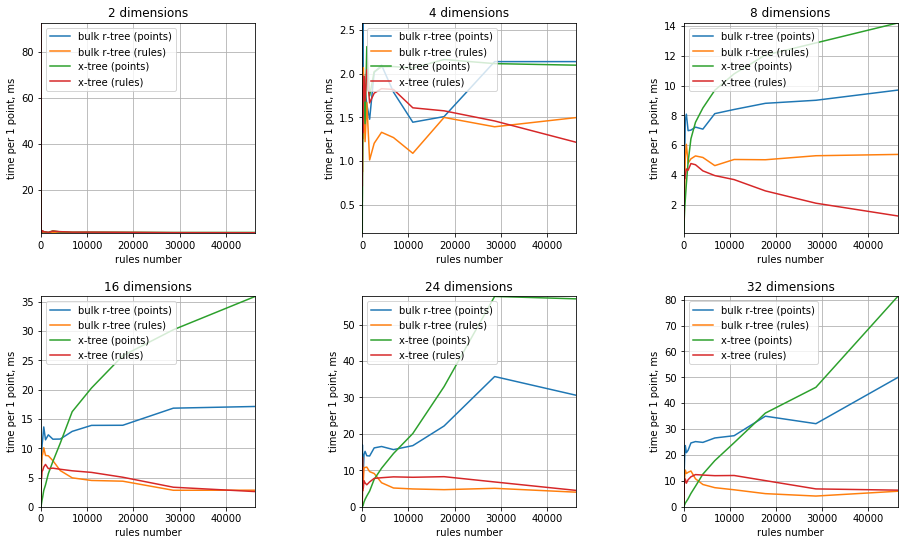

In [36]:
plotSpeedUp(resultDir, 'uniform')